# Influence functions wiht EK-FAC

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from support.common import plot_losses
from support.torch import fit_torch_model
from pydvl.influence import compute_influence_factors, compute_influences_up
from pydvl.influence.torch import TorchTwiceDifferentiable
from support.shapley import load_wine_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr, spearmanr

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def print_error_stats(arr1, arr2, tag):
    print(
        f"Percentage error {tag}:{np.nanmean((np.abs(arr1 - arr2)/np.abs(arr2)))*100} %"
    )
    print(f"Pearson Correlation {tag}", pearsonr(arr1, arr2))
    print(f"Spearman Correlation {tag}", spearmanr(arr1, arr2))

In [4]:
from numpy import require


input_size = 13
middle_layers = []
output_size = 3
classification = True

train_dataset = th.utils.data.TensorDataset(
    th.randn(100, input_size), th.randint(0, output_size, (100,))
)
val_dataset = th.utils.data.TensorDataset(
    th.randn(100, input_size), th.randint(0, output_size, (100,))
)
# loss = lambda x, y: F.cross_entropy(x, y, reduction="sum")
loss = F.cross_entropy

loader = th.utils.data.DataLoader(train_dataset, batch_size=10)

layers = []
layers_size = [input_size] + middle_layers + [output_size]
new_layer = nn.Linear(input_size, input_size)
for param in new_layer.parameters():
    param.requires_grad = False
layers.append(new_layer)

for frm, to in zip(layers_size[:-1], layers_size[1:]):
    layers.append(nn.Linear(frm, to))
    layers.append(nn.Tanh())
layers.append(nn.Softmax(dim=-1))
model = nn.Sequential(*layers)

In [5]:
optimizer = Adam(model.parameters(), lr=0.01)
losses = fit_torch_model(
    model,
    training_data=train_dataset,
    val_data=val_dataset,
    loss=loss,
    optimizer=optimizer,
    num_epochs=100,
)

Model fitting:   0%|          | 0/100 [00:00<?, ?it/s]

Model fitting: 100%|██████████| 100/100 [00:05<00:00, 19.75it/s]


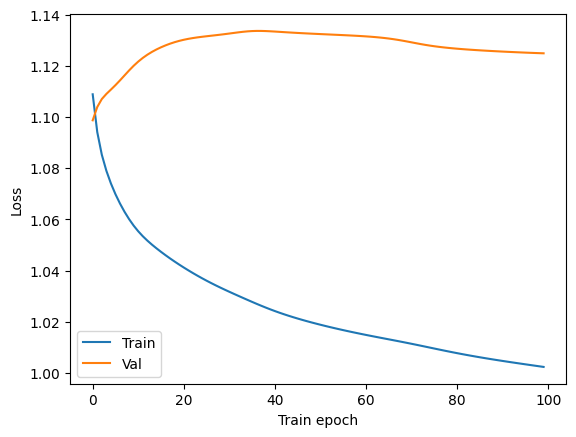

In [6]:
plot_losses(losses)

In [7]:
model.eval()
wrapped_model = TorchTwiceDifferentiable(model, loss)

In [8]:
direct_if_factors, direct_info = compute_influence_factors(
    wrapped_model,
    training_data=loader,
    test_data=loader,
    inversion_method="direct",
    hessian_perturbation=0.1,
    progress=False,
)
direct_influences = compute_influences_up(
    wrapped_model, loader, direct_if_factors, progress=True
)
mean_direct_influences = np.mean(direct_influences.numpy(), axis=0)
direct_hessian = direct_info["hessian"]

Batch Split Input Gradients: 100%|██████████| 10/10 [00:00<00:00, 353.37it/s]


In [9]:
np.any(np.isnan(direct_influences.numpy()))

False

In [10]:
ekfac_if_factors, ekfac_info = compute_influence_factors(
    wrapped_model,
    training_data=loader,
    test_data=loader,
    inversion_method="ekfac",
    hessian_perturbation=0.1,
    update_diag=True,
    progress=True,
)
ekfac_influences = compute_influences_up(
    wrapped_model, loader, ekfac_if_factors, progress=True
)
mean_ekfac_influences = np.mean(ekfac_influences.numpy(), axis=0)
ekfac_hessian = ekfac_info["hessian"]

Batch Split Input Gradients: 100%|██████████| 10/10 [00:00<00:00, 361.63it/s]


In [11]:
np.any(np.isnan(ekfac_influences.numpy()))

False

In [12]:
print_error_stats(mean_ekfac_influences, mean_direct_influences, tag="influence values")

Percentage error influence values:18.42445135116577 %
Pearson Correlation influence values PearsonRResult(statistic=0.995811825027853, pvalue=1.2361788054198864e-103)
Spearman Correlation influence values SignificanceResult(statistic=0.9985358535853585, pvalue=5.680268956173512e-126)


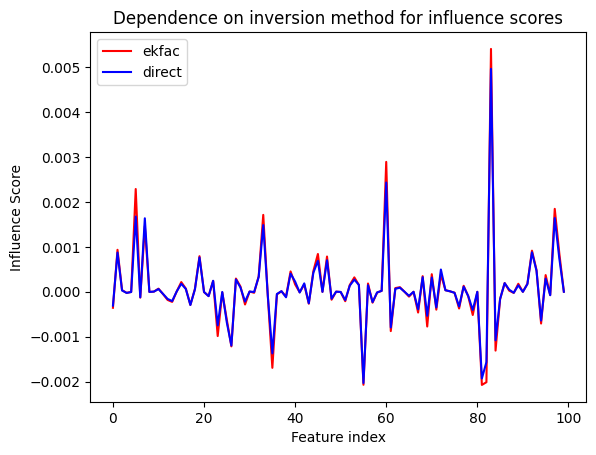

In [13]:
plt.plot(mean_ekfac_influences, color="red")
plt.plot(mean_direct_influences, color="blue")
plt.legend(["ekfac", "direct"])
plt.xlabel("Feature index")
plt.ylabel("Influence Score")
plt.title("Dependence on inversion method for influence scores")
plt.show()

In [14]:
direct_eig = np.linalg.eig(direct_hessian)[0]
ekfac_eig = np.linalg.eig(ekfac_hessian)[0]

In [15]:
print_error_stats(direct_eig.real, ekfac_eig.real, tag="eigen values")

Percentage error eigen values:15419.551086425781 %
Pearson Correlation eigen values PearsonRResult(statistic=0.9482945698550909, pvalue=1.527274579557927e-21)
Spearman Correlation eigen values SignificanceResult(statistic=0.8737541528239203, pvalue=4.2879636947069186e-14)


In [16]:
np.sum(direct_hessian.numpy() == 0)

0

In [17]:
ekfac_hessian - direct_hessian

tensor([[-3.8414e-03,  1.1048e-03,  1.3845e-03,  ..., -5.2892e-03,
          2.4940e-05,  4.3315e-04],
        [ 1.1048e-03, -5.6703e-03, -1.7893e-03,  ...,  5.5150e-03,
         -2.1225e-05, -3.2964e-04],
        [ 1.3845e-03, -1.7893e-03, -4.3862e-03,  ...,  3.3297e-03,
          8.6172e-06, -2.2791e-04],
        ...,
        [-5.2892e-03,  5.5150e-03,  3.3297e-03,  ..., -1.4625e-02,
          6.0132e-05,  7.5741e-04],
        [ 2.4940e-05, -2.1225e-05,  8.6172e-06,  ...,  6.0132e-05,
         -9.8798e-03,  4.5940e-04],
        [ 4.3315e-04, -3.2964e-04, -2.2791e-04,  ...,  7.5741e-04,
          4.5940e-04, -1.9224e-02]])